In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
%matplotlib inline

In [2]:
df = pd.read_csv('clean_full_movie_data.csv')
df

C:\Users\HP\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (4,5,6,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,movie_titles,genres,original_language,release_date,studio,production_budget,domestic_gross,foreign_gross,worldwide_gross,revenue,runtime,popularity,production_companies,production_countries,vote_average,vote_count
0,toy story 3,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",en,2010-06-16,BV,200000000,"$415,004,880",652000000,"$1,068,879,522",1066969703,103.0,16.966470,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",7.6,4710.0
1,inception,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",en,2010-07-14,WB,160000000,"$292,576,195",535700000,"$835,524,642",825532764,148.0,29.108149,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",8.1,14075.0
2,shrek forever after,"[{'id': 35, 'name': 'Comedy'}, {'id': 12, 'nam...",en,2010-05-16,P/DW,165000000,"$238,736,787",513900000,"$756,244,673",752600867,93.0,11.803808,"[{'name': 'DreamWorks Animation', 'id': 521}]","[{'iso_3166_1': 'US', 'name': 'United States o...",6.0,2021.0
3,the twilight saga: eclipse,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,2010-06-23,Sum.,68000000,"$300,531,751",398000000,"$706,102,828",698491347,124.0,34.047399,"[{'name': 'Summit Entertainment', 'id': 491}, ...","[{'iso_3166_1': 'US', 'name': 'United States o...",5.9,2382.0
4,iron man 2,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",en,2010-04-28,Par.,200000000,"$312,433,331",311500000,"$621,156,389",623933331,124.0,19.083344,"[{'name': 'Marvel Studios', 'id': 420}]","[{'iso_3166_1': 'US', 'name': 'United States o...",6.6,6969.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45744,stories of our lives,"[{""id"": 18, ""name"": ""Drama""}]",en,2014-09-05,NaN,0,NaN,NaN,NaN,0,60.0,0.327794,[],"[{""iso_3166_1"": ""KE"", ""name"": ""Kenya""}]",0.0,0.0
45745,tin can man,"[{""id"": 27, ""name"": ""Horror""}]",en,2007-01-01,NaN,13,NaN,NaN,NaN,0,84.0,0.332679,"[{""name"": ""Park Films"", ""id"": 21871}, {""name"":...","[{""iso_3166_1"": ""IE"", ""name"": ""Ireland""}]",2.0,1.0
45746,on the downlow,"[{""id"": 18, ""name"": ""Drama""}]",en,2004-04-11,NaN,0,NaN,NaN,NaN,0,90.0,0.029757,"[{""name"": ""Iconoclast Films"", ""id"": 26677}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",6.0,2.0
45747,sanctuary: quite a conundrum,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 27, ""n...",en,2012-01-20,NaN,0,NaN,NaN,NaN,0,82.0,0.166513,"[{""name"": ""Gold Lion Films"", ""id"": 37870}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",0.0,0.0


In [3]:
def dataset_summary(df):

    print("Shape (rows, columns):")
    print(df.shape)
    print("Info:")
    print(df.info())
    print("Statistical Summary (numerical columns):")
    print(df.describe().T)     # the .T makes it easier to read in transpose form
    
dataset_summary(df)

Shape (rows, columns):
(45749, 16)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45749 entries, 0 to 45748
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_titles          45748 non-null  object 
 1   genres                45603 non-null  object 
 2   original_language     45592 non-null  object 
 3   release_date          45748 non-null  object 
 4   studio                1469 non-null   object 
 5   production_budget     45748 non-null  object 
 6   domestic_gross        1470 non-null   object 
 7   foreign_gross         1274 non-null   object 
 8   worldwide_gross       1470 non-null   object 
 9   revenue               45748 non-null  object 
 10  runtime               45355 non-null  float64
 11  popularity            45603 non-null  float64
 12  production_companies  45603 non-null  object 
 13  production_countries  45603 non-null  object 
 14  vote_average          45603 n

In [4]:
df.isna().sum()

movie_titles                1
genres                    146
original_language         157
release_date                1
studio                  44280
production_budget           1
domestic_gross          44279
foreign_gross           44475
worldwide_gross         44279
revenue                     1
runtime                   394
popularity                146
production_companies      146
production_countries      146
vote_average              146
vote_count                146
dtype: int64

In [5]:
# Since revenue is the same as gross we will drop the domestic, foreign and worldwide gross columns since they have alot of missing values and the revenue column has less missing vvalues
#Drop all the columns not needed in this analysis.
columns_to_drop = [
    'domestic_gross',
    'foreign_gross',
    'worldwide_gross',
    'studio',
    'original_language',
]
df = df.drop(columns=columns_to_drop)


In [6]:
df.isna().sum()

movie_titles              1
genres                  146
release_date              1
production_budget         1
revenue                   1
runtime                 394
popularity              146
production_companies    146
production_countries    146
vote_average            146
vote_count              146
dtype: int64

In [7]:
# Ensure the columns are numeric
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['production_budget'] = pd.to_numeric(df['production_budget'], errors='coerce')
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')

# Format the date and time as well as remove the $ and commas inthe money related columns
df['release_date'] = df['release_date'].dt.strftime('%Y-%m-%d')
df['production_budget'] = df['production_budget'].replace('[\$,]', '', regex=True).astype(float)
df['revenue'] = df['revenue'].replace('[\$,]', '', regex=True).astype(float)

In [8]:
df['profit'] = df['revenue'] - df['production_budget']

In [9]:
# Extract each genre name from the string text
genre_extracted = df['genres'].str.extractall(r"name': '([^']+)'")

# Add the extracted genre names back to the dataframe
df_genres = df.join(
    genre_extracted.reset_index(level=1, drop=True).rename(columns={0: 'genre_list'})
)

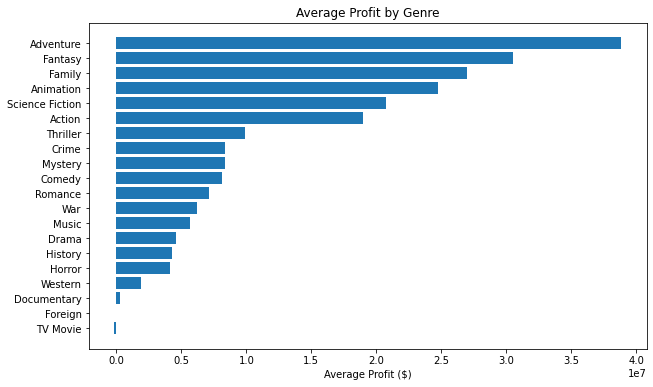

In [10]:
# Genre vs Profit
genre_profit = df_genres.groupby('genre_list')['profit'].mean().sort_values()

plt.figure(figsize=(10,6))
plt.barh(genre_profit.index, genre_profit.values)
plt.xlabel("Average Profit ($)")
plt.title("Average Profit by Genre")
plt.show()

<ipython-input-11-8f5d34698b2f>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}B'.format(x/1e9) for x in current_values])
<ipython-input-11-8f5d34698b2f>:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


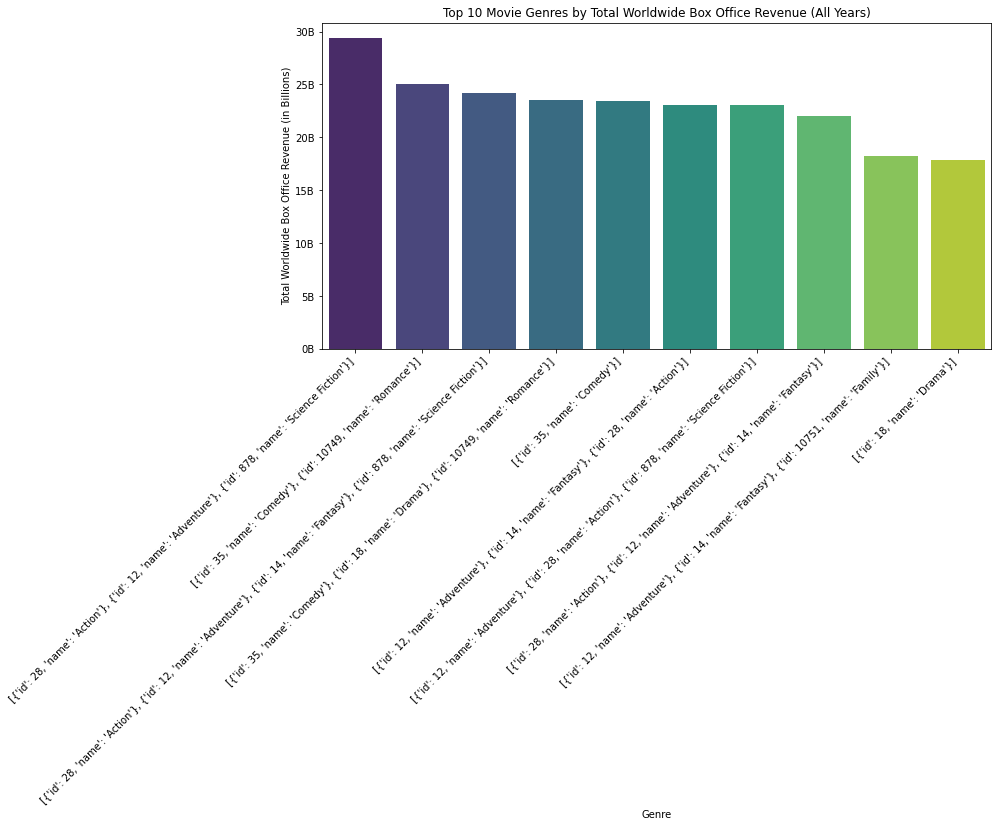

In [11]:
# Genre vs Revenue
# 1. Total Revenue by Genre
"""
genre_revenue = df_genres.groupby('genres')['revenue'].mean().sort_values()

plt.figure(figsize=(10,6))
plt.barh(genre_revenue.index, genre_revenue.values)
plt.xlabel("Average Revenue ($)")
plt.title("Average Revenue by Genre")
plt.show()
""""


genre_revenue = df_genres.groupby('genres')['revenue'].sum().sort_values(ascending=False)
top_10_genres = genre_revenue.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_genres.index, y=top_10_genres.values, palette='viridis')
plt.title('Top 10 Movie Genres by Total Worldwide Box Office Revenue (All Years)')
plt.xlabel('Genre')
plt.ylabel('Total Worldwide Box Office Revenue (in Billions)')
# Format y-axis to be in billions for better readability
plt.ticklabel_format(style='plain', axis='y')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}B'.format(x/1e9) for x in current_values])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_10_genres_revenue_bar_chart.png')
plt.show()
plt.close()

In [ ]:
#Genre vs Ratings
# Average rating per genre
genre_ratings = df_genres.groupby('genres')['vote_average'].mean().sort_values()

plt.figure(figsize=(10,6))
plt.barh(genre_ratings.index, genre_ratings.values)
plt.xlabel("Average Rating")
plt.title("Average Ratings by Genre")
plt.show()

<ipython-input-12-63362e9bac6d>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}M'.format(x/1e6) for x in current_values])
<ipython-input-12-63362e9bac6d>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


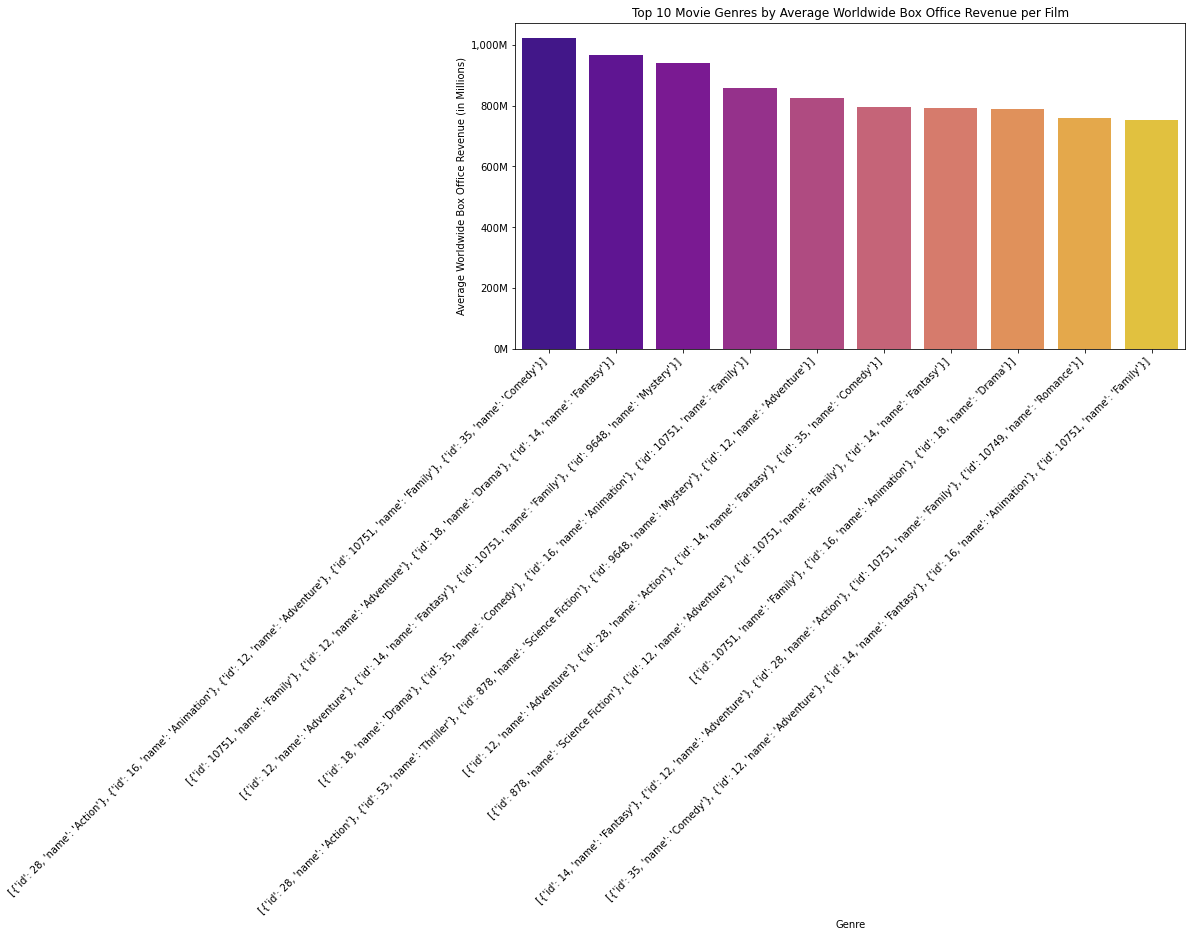

In [12]:
# Average Revenue per Film by Genre
genre_avg_revenue = df_genres.groupby('genres')['revenue'].mean().sort_values(ascending=False)
top_10_avg_genres = genre_avg_revenue.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_avg_genres.index, y=top_10_avg_genres.values, palette='plasma')
plt.title('Top 10 Movie Genres by Average Worldwide Box Office Revenue per Film')
plt.xlabel('Genre')
plt.ylabel('Average Worldwide Box Office Revenue (in Millions)')
# Format y-axis to be in millions for better readability
plt.ticklabel_format(style='plain', axis='y')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}M'.format(x/1e6) for x in current_values])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_10_genres_avg_revenue_bar_chart.png')
plt.show()
plt.close()

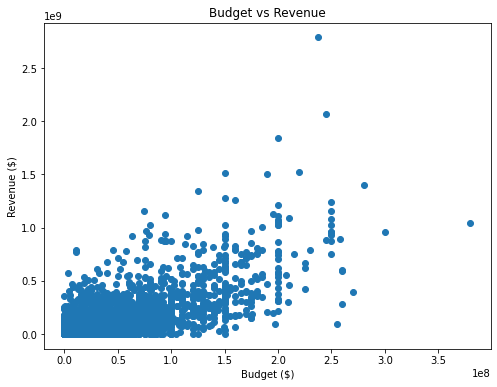

In [13]:
# Budget vs Revenue
plt.figure(figsize=(8,6))
plt.scatter(df['production_budget'], df['revenue'])
plt.xlabel("Budget ($)")
plt.ylabel("Revenue ($)")
plt.title("Budget vs Revenue")
plt.show()

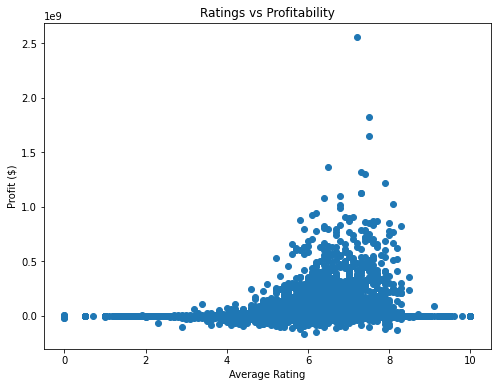

In [14]:
# Ratings vs profits
plt.figure(figsize=(8,6))
plt.scatter(df['vote_average'], df['profit'])
plt.xlabel("Average Rating")
plt.ylabel("Profit ($)")
plt.title("Ratings vs Profitability")
plt.show()

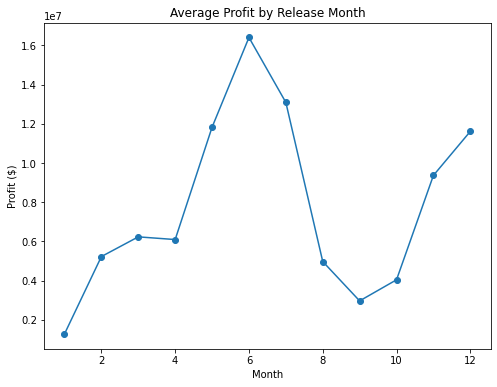

In [15]:
#Seasons vs Profits
df['release_date'] = pd.to_datetime(df['release_date'])
df['release_month'] = df['release_date'].dt.month

month_profit = df.groupby('release_month')['profit'].mean()

plt.figure(figsize=(8,6))
plt.plot(month_profit.index, month_profit.values, marker='o')
plt.title("Average Profit by Release Month")
plt.xlabel("Month")
plt.ylabel("Profit ($)")
plt.show()

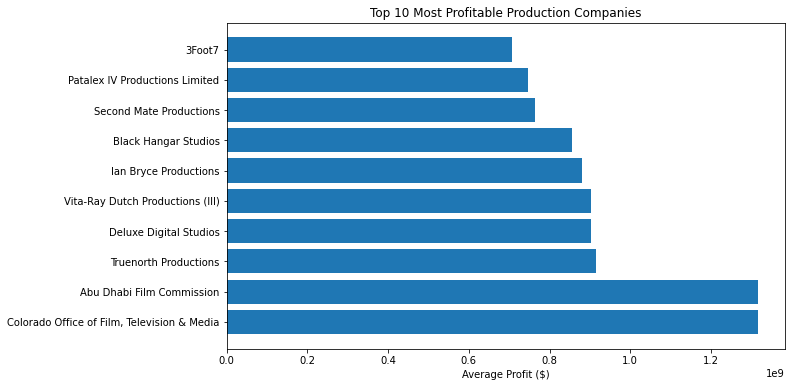

In [16]:
# Profitable companies

# Extract each company name from the production_companies text
company_extracted = df['production_companies'].str.extractall(r"name': '([^']+)'")

# Add extracted company names back to dataframe
df_companies = df.join(
    company_extracted.reset_index(level=1, drop=True).rename(columns={0: 'company_list'})
)

company_profit = df_companies.groupby('company_list')['profit'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(company_profit.index, company_profit.values)
plt.title("Top 10 Most Profitable Production Companies")
plt.xlabel("Average Profit ($)")
plt.show()